# TP4 - Classification de survie d'une entreprise

Dataset - https://www.kaggle.com/datasets/fedesoriano/company-bankruptcy-prediction/

## Data Processing

### Loading Data

In [1]:
import pandas as pd

# Load data from data.csv with the first row as the header row
df = pd.read_csv('data.csv', header=0)

In [2]:
# Display the loaded data
df

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,...,0.799927,0.000466,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,1,0.029890
6815,0,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,...,0.799748,0.001959,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,1,0.038284
6816,0,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,...,0.797778,0.002840,0.624156,0.610441,0.840138,0.275789,0.026791,0.565158,1,0.097649
6817,0,0.506264,0.559911,0.554045,0.607850,0.607850,0.999074,0.797500,0.809399,0.303498,...,0.811808,0.002837,0.623957,0.607846,0.841084,0.277547,0.026822,0.565302,1,0.044009


#### Data resampling

In [3]:
# Downsample the 0 class
df_downsampled = pd.concat([df[df['Bankrupt?'] == 0].sample(
    df[df['Bankrupt?'] == 1].shape[0], random_state=42), df[df['Bankrupt?'] == 1]])

In [4]:
# # Upsample the 1 class
# df_upsampled = pd.concat([df[df['Bankrupt?'] == 0], df[df['Bankrupt?'] == 1].sample(
#     df[df['Bankrupt?'] == 0].shape[0], replace=True, random_state=42)])

In [5]:
# Info
print(f'Lost {df.shape[0] - df_downsampled.shape[0]} rows')
print(f'New shape: {df_downsampled.shape}')

Lost 6379 rows
New shape: (440, 96)


In [6]:
# Reassign df
del df
df = df_downsampled

#### Separate columns

In [7]:
# Separate into labels and features
labels = df['Bankrupt?']
features = df.drop('Bankrupt?', axis=1)

In [8]:
# Data repartition
rep_base = labels.value_counts()

print(f'Values repartition: {rep_base[0] / labels.shape[0]:.0%} non-bankrupt, {rep_base[1] / labels.shape[0]:.0%} bankrupt')

Values repartition: 50% non-bankrupt, 50% bankrupt


#### Scale data

In [9]:
from sklearn.preprocessing import MinMaxScaler

# Create a StandardScaler object
scaler = MinMaxScaler()

# Fit the scaler to the features
scaler.fit(features)

# Transform the features using the scaler
scaled_features = scaler.transform(features)

In [10]:
# Reassign features
del features
features = scaled_features

### Dimensionality reduction

In [49]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.manifold import Isomap

# Parameters
split_perc = 0.2

target_dim = 5
feature_extractors = [
    PCA(n_components=target_dim, random_state=42),
    SelectKBest(score_func=chi2, k=target_dim),
    RFE(estimator=SVC(kernel='linear'), n_features_to_select=target_dim, step=1),
    Isomap(n_components=target_dim)
]

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=split_perc, random_state=42)

spaces_splits = [('Base', X_train, X_test)]

for extractor in feature_extractors:
    extractor.fit(X_train, y_train)
    spaces_splits.append((extractor.__class__.__name__, extractor.transform(X_train), extractor.transform(X_test)))

In [51]:
rep_tr = y_train.value_counts()
rep_tst = y_test.value_counts()

print(f'Training values repartition: {rep_tr[0] / y_train.shape[0]:.0%} non-bankrupt, {rep_tr[1] / y_train.shape[0]:.0%} bankrupt')
print(f'Testing values repartition: {rep_tst[0] / y_test.shape[0]:.0%} non-bankrupt, {rep_tst[1] / y_test.shape[0]:.0%} bankrupt')

Training values repartition: 48% non-bankrupt, 52% bankrupt
Testing values repartition: 58% non-bankrupt, 42% bankrupt


#### Visualisation of the data

Visualise the data and the dim reduced data on a 2d plane

In [52]:
import matplotlib.pyplot as plt
import numpy as np

def plot_2d_space(spaces, red_method):
    n_rows = len(spaces) // 2 + len(spaces) % 2

    fig, axs = plt.subplots(n_rows, 2, figsize=(10, 5 * n_rows))
    
    for i, space in enumerate(spaces):
        red_space = space[1] if red_method is None else red_method(np.concatenate((space[1], space[2]), axis=0))
        axs[i // 2, i % 2].scatter(red_space[:, 0], red_space[:, 1], c=labels, s=5)

    plt.show()

##### Using PCA

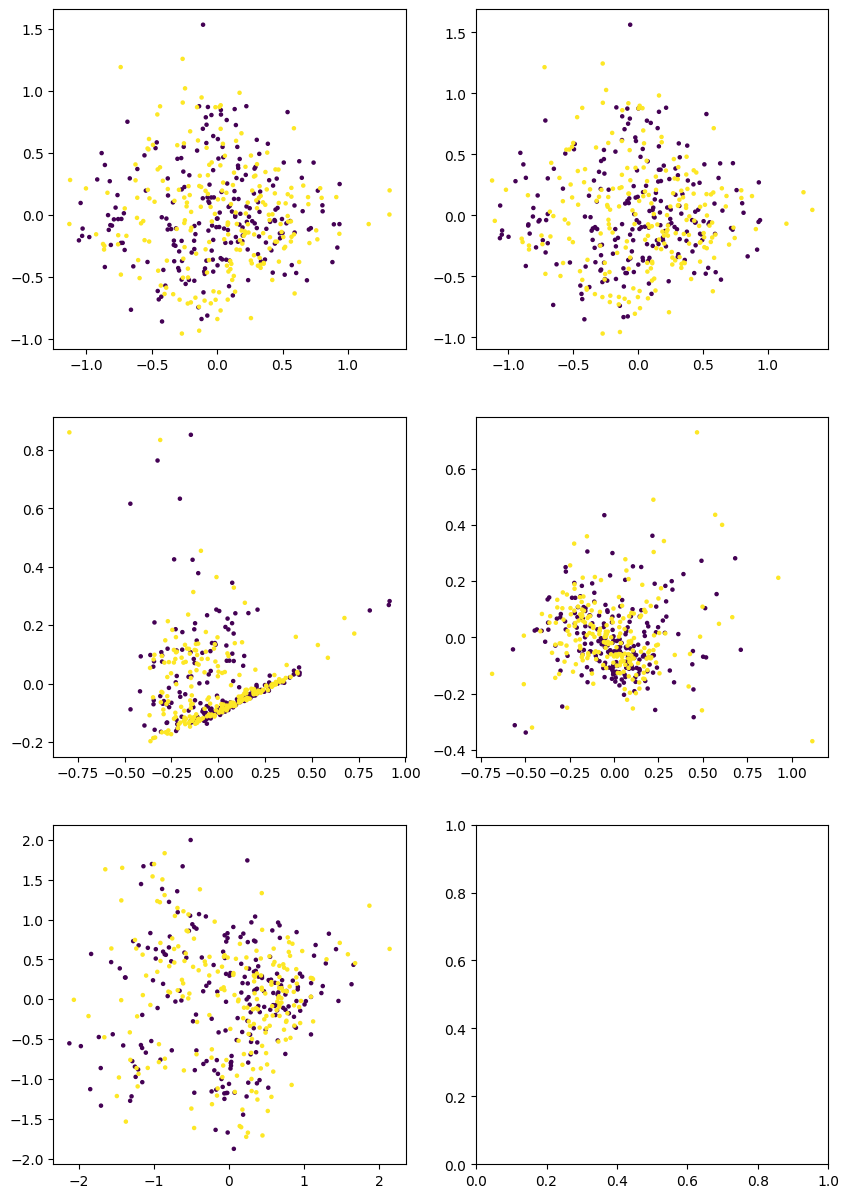

In [53]:
plot_2d_space(
    spaces_splits, 
    lambda space: PCA(n_components=2, random_state=42).fit_transform(space)
    )

##### Using TSNE

In [54]:
from sklearn.manifold import TSNE

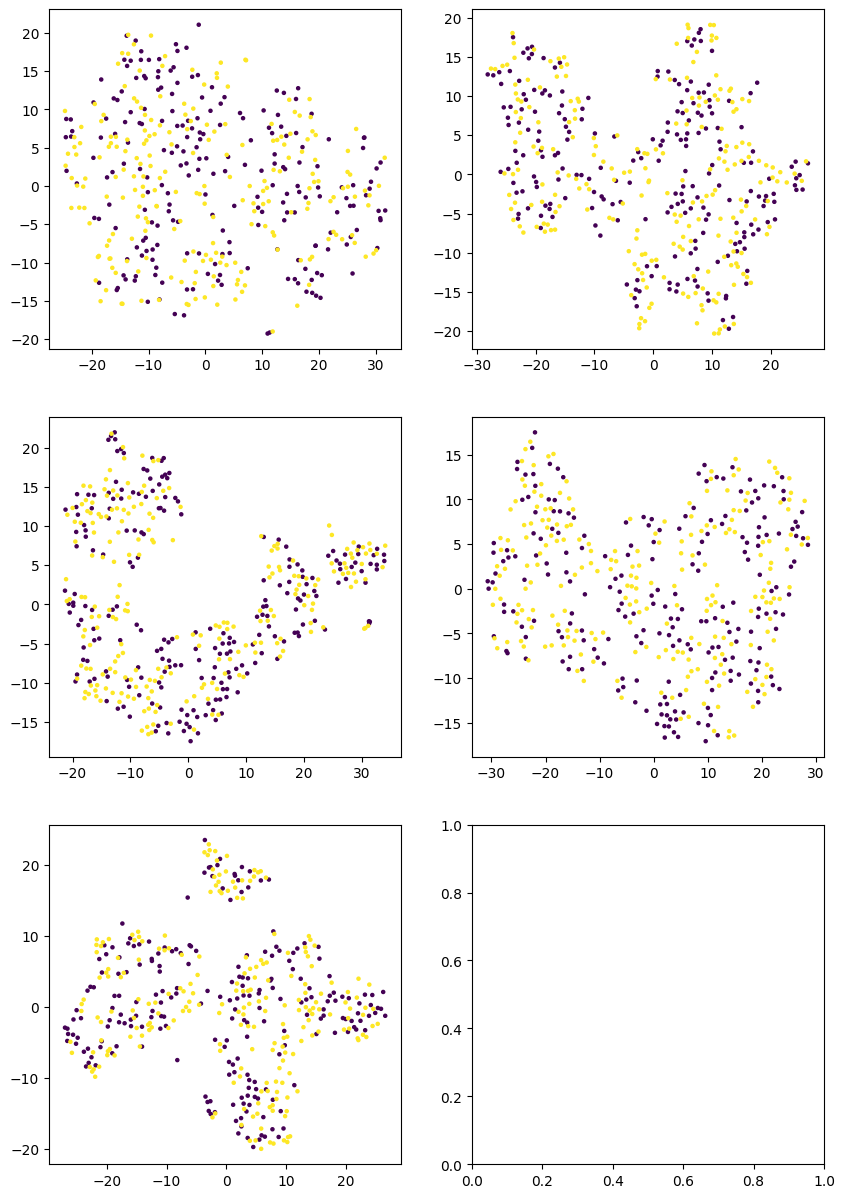

In [55]:
plot_2d_space(
    spaces_splits, 
    lambda space: TSNE(n_components=2, random_state=42).fit_transform(space)
)

## Classification

In [56]:
from sklearn.metrics import accuracy_score

In [57]:
def _train_pred(space, model, **kwargs):

        _model = model(**kwargs)

        _model.fit(space[1], y_train)

        y_pred = _model.predict(space[2])
        _accuracy =  accuracy_score(y_test, y_pred)

        print(f'{space[0]} accuracy: {_accuracy:.2%}')

        return (_model, _accuracy)

def train_pred(model, **kwargs):
    
    return [_train_pred(space, model, **kwargs) for space in spaces_splits]


In [58]:
import numpy as np

def test_proba(models):

        def _pred_proba(model, space):
            
                probas =  model.predict_proba(space[2])

                y_pred = np.argmax(probas, axis=1)
                _accuracy =  accuracy_score(y_test, y_pred)

                print(' ')
                print(f'{space[0]} accuracy: {_accuracy:.2%}')

                avg_proba_wrg = np.mean(np.max(probas, axis=1)[y_pred != y_test], axis=0)

                print(f'Average top confidance: {np.mean(np.max(probas, axis=1)):.2%}')
                print(f'Average confidance when wrong: {avg_proba_wrg:.2%}')

                return (avg_proba_wrg, _accuracy)
    
        return [_pred_proba(models[i], spaces_splits[i]) for i in range(len(spaces_splits))]

### State Vector Machine

In [59]:
from sklearn.svm import SVC

train_pred(SVC)

print('')

Base accuracy: 86.36%
PCA accuracy: 84.09%
SelectKBest accuracy: 85.23%
RFE accuracy: 85.23%
Isomap accuracy: 79.55%



#### SVM - Proba

In [60]:
svc_prob = train_pred(SVC, probability=True)

test_proba([el[0] for el in svc_prob])

print('')

Base accuracy: 86.36%
PCA accuracy: 84.09%
SelectKBest accuracy: 85.23%
RFE accuracy: 85.23%
Isomap accuracy: 79.55%
 
Base accuracy: 86.36%
Average top confidance: 83.32%
Average confidance when wrong: 76.19%
 
PCA accuracy: 82.95%
Average top confidance: 82.65%
Average confidance when wrong: 76.45%
 
SelectKBest accuracy: 85.23%
Average top confidance: 80.68%
Average confidance when wrong: 75.24%
 
RFE accuracy: 86.36%
Average top confidance: 85.99%
Average confidance when wrong: 77.93%
 
Isomap accuracy: 79.55%
Average top confidance: 82.40%
Average confidance when wrong: 75.60%



#### Nu-SVM

In [61]:
from sklearn.svm import NuSVC

train_pred(NuSVC)

print('')

Base accuracy: 84.09%
PCA accuracy: 84.09%
SelectKBest accuracy: 85.23%
RFE accuracy: 85.23%
Isomap accuracy: 78.41%



### Binary tree

In [62]:
from sklearn.tree import DecisionTreeClassifier

train_pred(DecisionTreeClassifier, random_state=42)

print('')

Base accuracy: 79.55%
PCA accuracy: 77.27%
SelectKBest accuracy: 84.09%
RFE accuracy: 79.55%
Isomap accuracy: 62.50%



#### Random Forest

In [63]:
from sklearn.ensemble import RandomForestClassifier

train_pred(RandomForestClassifier, random_state=42)

print('')

Base accuracy: 85.23%
PCA accuracy: 84.09%
SelectKBest accuracy: 85.23%
RFE accuracy: 79.55%
Isomap accuracy: 81.82%



### K-nearest neighboors

In [64]:
from sklearn.neighbors import KNeighborsClassifier

train_pred(KNeighborsClassifier, n_neighbors=10)

print('')

Base accuracy: 82.95%
PCA accuracy: 77.27%
SelectKBest accuracy: 81.82%
RFE accuracy: 84.09%
Isomap accuracy: 76.14%



In [65]:
# On base find best k
k_nn_range = range(1, 30)

top_val_knn = 0
top_knn_k = 0

for i in k_nn_range:

    print(f'k = {i} : ', end='')
    val_knn_base = _train_pred(spaces_splits[0], KNeighborsClassifier, n_neighbors=i)[1]

    if val_knn_base > top_val_knn:
        top_val_knn = val_knn_base
        top_knn_k = i

print(f'Best k: {top_knn_k} with {top_val_knn:.2%}')

k = 1 : Base accuracy: 68.18%
k = 2 : Base accuracy: 73.86%
k = 3 : Base accuracy: 69.32%
k = 4 : Base accuracy: 71.59%
k = 5 : Base accuracy: 77.27%
k = 6 : Base accuracy: 79.55%
k = 7 : Base accuracy: 77.27%
k = 8 : Base accuracy: 80.68%
k = 9 : Base accuracy: 79.55%
k = 10 : Base accuracy: 82.95%
k = 11 : Base accuracy: 78.41%
k = 12 : Base accuracy: 76.14%
k = 13 : Base accuracy: 72.73%
k = 14 : Base accuracy: 73.86%
k = 15 : Base accuracy: 71.59%
k = 16 : Base accuracy: 75.00%
k = 17 : Base accuracy: 72.73%
k = 18 : Base accuracy: 72.73%
k = 19 : Base accuracy: 73.86%
k = 20 : Base accuracy: 76.14%
k = 21 : Base accuracy: 76.14%
k = 22 : Base accuracy: 77.27%
k = 23 : Base accuracy: 77.27%
k = 24 : Base accuracy: 79.55%
k = 25 : Base accuracy: 77.27%
k = 26 : Base accuracy: 79.55%
k = 27 : Base accuracy: 77.27%
k = 28 : Base accuracy: 78.41%
k = 29 : Base accuracy: 78.41%
Best k: 10 with 82.95%


## Classification - Clustering

### KMeans

In [66]:
from sklearn.cluster import KMeans

class KMeans_Classifier:
    def __init__(self, n_clust=2):

        self.model = KMeans(n_clusters=n_clust, n_init='auto', random_state=42)
        self.tree = DecisionTreeClassifier(random_state=42)

    def fit(self, X, y):

        # Fit DBSCAN model
        self.model.fit(X)

        # Fit classes to labels with decision tree
        self.tree.fit(
            self.model.predict(X).reshape(-1, 1),
            y
        )

    def predict(self, X):
        return self.tree.predict(
            self.model.predict(X).reshape(-1, 1)
        )

train_pred(KMeans_Classifier, n_clust=27)

print('')

Base accuracy: 73.86%
PCA accuracy: 72.73%
SelectKBest accuracy: 85.23%
RFE accuracy: 84.09%
Isomap accuracy: 77.27%



In [67]:
# On base find best k
k_km_range = range(1, 50)

top_val_km = 0
top_km_k = 0

for i in k_km_range:

    print(f'k = {i} : ', end='')
    val_km_base = _train_pred(spaces_splits[0], KMeans_Classifier, n_clust=i)[1]

    if val_km_base > top_val_km:
        top_val_km = val_km_base
        top_km_k = i

print(f'Best k: {top_km_k} with {top_val_km:.2%}')

k = 1 : Base accuracy: 42.05%
k = 2 : Base accuracy: 61.36%
k = 3 : Base accuracy: 54.55%
k = 4 : 

Base accuracy: 72.73%
k = 5 : Base accuracy: 65.91%
k = 6 : Base accuracy: 62.50%
k = 7 : Base accuracy: 61.36%
k = 8 : Base accuracy: 56.82%
k = 9 : Base accuracy: 63.64%
k = 10 : Base accuracy: 62.50%
k = 11 : Base accuracy: 56.82%
k = 12 : Base accuracy: 53.41%
k = 13 : Base accuracy: 50.00%
k = 14 : Base accuracy: 57.95%
k = 15 : Base accuracy: 48.86%
k = 16 : Base accuracy: 56.82%
k = 17 : Base accuracy: 61.36%
k = 18 : Base accuracy: 59.09%
k = 19 : Base accuracy: 60.23%
k = 20 : Base accuracy: 60.23%
k = 21 : Base accuracy: 71.59%
k = 22 : Base accuracy: 71.59%
k = 23 : Base accuracy: 68.18%
k = 24 : Base accuracy: 71.59%
k = 25 : Base accuracy: 71.59%
k = 26 : Base accuracy: 71.59%
k = 27 : Base accuracy: 73.86%
k = 28 : Base accuracy: 72.73%
k = 29 : Base accuracy: 71.59%
k = 30 : Base accuracy: 69.32%
k = 31 : Base accuracy: 68.18%
k = 32 : Base accuracy: 69.32%
k = 33 : Base accuracy: 69.32%
k = 34 : Base accuracy: 69.32%
k = 35 : Base accuracy: 67.05%
k = 36 : Base accuracy